In [ ]:
# !pip install datasets
# !pip install kaggle
# !pip install pydub
# !pip install ucimlrepo
# !pip install d2l


# ***can an auto-encoder classifies the data unsupervisedly ?***

## include evry thing we think we going to need

In [69]:
import torch
import torch.nn as nn
from pandas import Timedelta
# import torchvision
# import torchvision.transforms as transforms  # Import torchvision transforms module
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
from IPython.display import Audio
# from pydub import AudioSegment
# from pydub.generators import Sine
import numpy as np
import seaborn as sns
# import dask.array as da
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
# import tqdm
from tqdm import tqdm
# from tqdm.notebook import tqdm
import os
# from datasets import load_dataset
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce
import operator
import numpy as np
from PIL import Image
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.offline as pyo
import plotly.subplots as px_sub
import plotly.graph_objects as px_grph
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import math
import random
sns.set(style="darkgrid")  # You can use other Seaborn styles or create your own
sns.set_palette("dark")
import warnings
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning")
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.")


# import nltk
# from nltk.tokenize import sent_tokenize
# from transformers import AutoTokenizer
# from transformers import pipeline
import pandas as pd
# from ucimlrepo import fetch_ucirepo
from torch import nn
# from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
device

device(type='cpu')

In [99]:

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the autoencoder model with sparsity constraint
    
# Initialize the autoencoder and optimizer

# Convert training data to DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the training loop


## The model





I used sparsity_loss to force the energy to be in one coordinate of the vector. I still want to change this loss:

$$
\mathcal{L}(X) = \sum_{i=0}^{n} (\lVert x_i \rVert)^{\varepsilon} \\
$$
$$
\quad \varepsilon \in (0, 1) \\
\quad X = (x_1, x_2, x_3, \ldots, x_n) \\

$$
 
I believe if I use this loss, it will be better than L1Loss due to the graph of both losses.

Another note from the graph of the losses: if you just need to classify, use

$$
\mathcal{L}(X) = \prod_{i=0}^{n} (\lVert x_i \rVert)^{\varepsilon}
$$

because it will be 0 if there is at least one 0, and that's what you need in the case of a 2-dimensional vector with a 0 and non-0 coordinate in the vector.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_target=0.1, sparsity_weight=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU(),  
            nn.Linear(input_size, input_size),
        )
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def sparsity_loss(self, activations):
        mean_activations = torch.mean(activations, dim=0)
        l1_loss = torch.mean(torch.abs(mean_activations - self.sparsity_target))
        return self.sparsity_weight * l1_loss
    
input_size = X_train.shape[1]
hidden_size = 3  
autoencoder = Autoencoder(input_size, hidden_size).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [6]:
info = {
    "TOTAL" : [0] ,
    "SPARSITY": [0],
    "ACCU" :[0]
}

In [7]:
def accu_calcu(__out , __target , __model , __ok_loss):
    __model.eval()
    return ((torch.abs(__model(__out) - __target ) < __ok_loss )).sum().float().mean() / ( torch.prod(torch.tensor(__target.shape)) )

In [9]:
num_epochs = 8000
with tqdm(total=num_epochs, desc="EPOSH") as pbar:
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_sparsity_loss = 0.0
        for batch_data in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch_data
            autoencoder.train()
            # Forward pass
            outputs = autoencoder(inputs)
            reconstruction_loss = nn.L1Loss()(outputs, targets)  # Reconstruction loss
            sparsity_loss = autoencoder.sparsity_loss(autoencoder.encoder(inputs))  # Sparsity loss
            loss = reconstruction_loss + sparsity_loss  # Total loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_sparsity_loss += sparsity_loss.item()


        average_loss = total_loss / len(train_loader)
        average_sparsity_loss = total_sparsity_loss / len(train_loader)
        if (epoch % 10) == 0 : 
            info["TOTAL"].append(average_loss)
            info["SPARSITY"].append(average_sparsity_loss)
            autoencoder.eval()
            info["ACCU"].append(accu_calcu(X_test_tensor , X_test_tensor , autoencoder , 0.1).float().item())
        pbar.update(1)
        pbar.set_postfix({"Total Loss": average_loss,
                          "Sparsity Loss": average_sparsity_loss,
                          "ACCU" : info["ACCU"][-1]})


        
autoencoder.eval()

EPOSH: 100%|██████████| 8000/8000 [01:53<00:00, 70.50it/s, Total Loss=0.135, Sparsity Loss=0.00481, ACCU=0.592]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
)

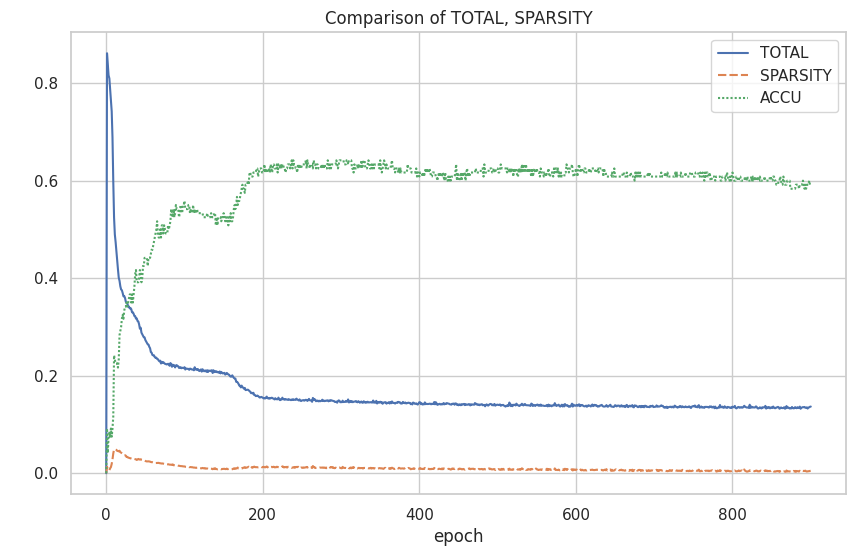

In [53]:
df_info = pd.DataFrame.from_dict({col : np.array(info[col]) for col in info})

# Plot using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_info )

plt.title('Comparison of TOTAL, SPARSITY')
plt.xlabel('epoch')
plt.ylabel(' ')
plt.show()

## calculating the acuurasy withe defrent threshold

/tmp/ipykernel_4562/698354106.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




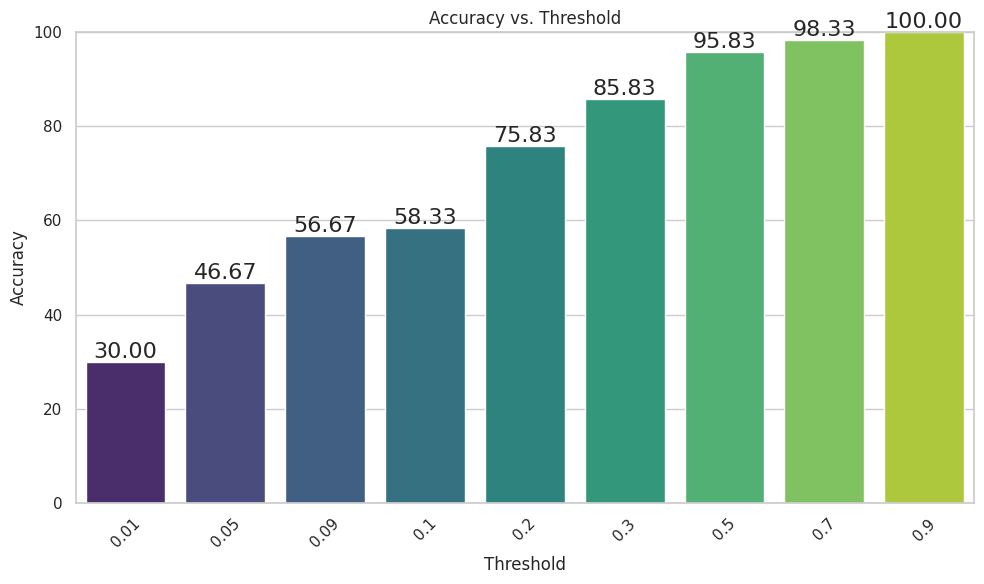

In [95]:
ACCU = {OK_LOSS: accu_calcu(X_test_tensor, X_test_tensor, autoencoder, OK_LOSS).float().item() * 100
        for OK_LOSS in (0.9,0.7,0.5, 0.3, 0.2, 0.1, 0.09, 0.05, 0.01)}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(ACCU, orient='index', columns=['Accuracy'])
df.index.name = 'Threshold'

# Reset index for plotting
df.reset_index(inplace=True)

# Plot using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Threshold', y='Accuracy', data=df, palette='viridis')
for i in range(len(df)):
        ax.bar_label(ax.containers[i],fmt='%.2f', fontsize=16);
    
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 100)
 
plt.tight_layout()
"""
this acuu the persentig of prediction that have an eroor bitween (+/- The Threshold)
"""
plt.show()

## testing the clasification 

In [98]:
Y_test_tensor

NameError: name 'Y_test_tensor' is not defined

In [103]:
df

,X,Y,Z,class
0,0.121546,0.000000,0.144781,NaN
1,0.000000,0.317409,0.075584,NaN
2,0.468919,0.000000,0.115226,NaN
3,0.091495,0.000000,0.133677,NaN
4,0.160869,0.000000,0.137570,NaN
5,0.000000,0.275711,0.132345,NaN
6,0.000000,0.012129,0.153207,NaN
7,0.172071,0.000000,0.086151,NaN
8,0.229484,0.000000,0.223932,NaN
9,0.052002,0.000000,0.173615,NaN


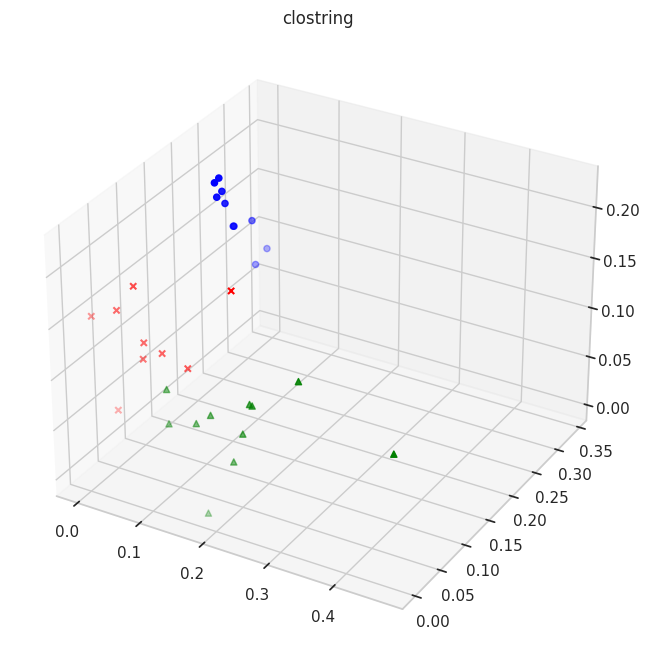

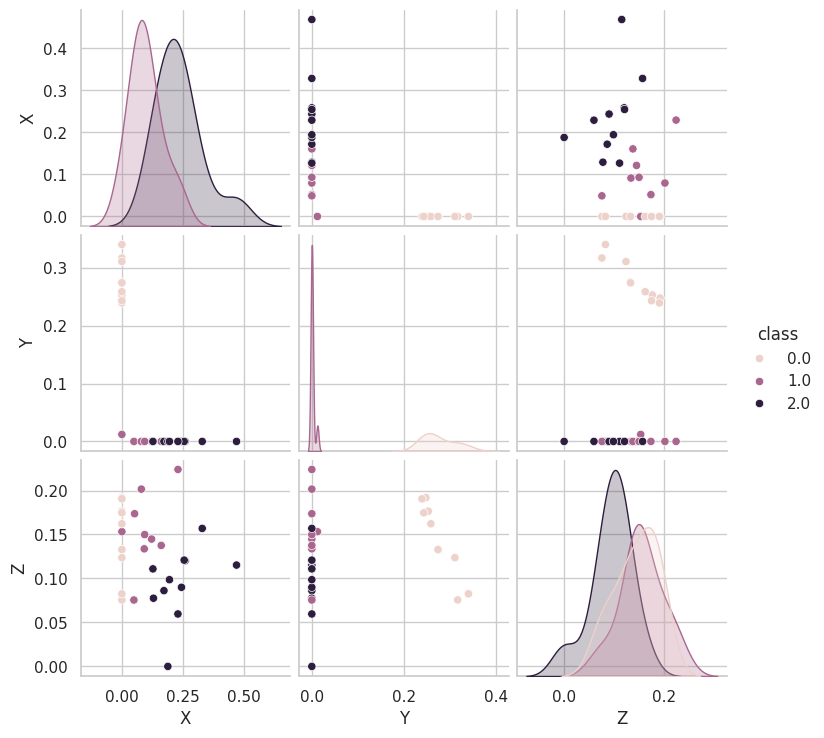

In [106]:
X_list_test = autoencoder.encoder(X_test_tensor).tolist()
Y_list_test = Y_test_tensor


# Create a DataFrame for both test and train data
X_test = pd.DataFrame(X_list_test, columns=['X', 'Y', 'Z'])
Y_test = pd.DataFrame(Y_list_test, columns=['class'])

# df = pd.concat([X_test  , Y_test])
df = pd.merge(X_test  , Y_test, left_index=True, right_index=True, suffixes=('_train', '_test'))



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot
 

ax.scatter( df[df['class'] == 0]['X'],
            df[df['class'] == 0]['Y'],
            df[df['class'] == 0]['Z'],
            c='blue', 
            marker='o', 
            label='0')
ax.scatter( df[df['class'] == 1]['X'],
            df[df['class'] == 1]['Y'],
            df[df['class'] == 1]['Z'],
            c='red', 
            marker='x', 
            label='1')
ax.scatter( df[df['class'] == 2]['X'],
            df[df['class'] == 2]['Y'],
            df[df['class'] == 2]['Z'],
            c='green', 
            marker='^', 
            label='2')

ax.set_title('clostring')
# ax.legend(title='Dataset')
plt.show()

sns.pairplot(df , hue="class")
plt.show()

## run it for all the data

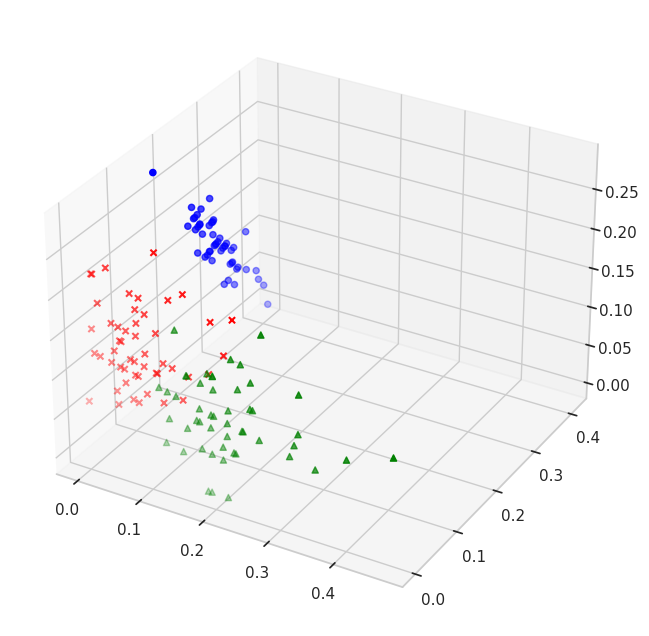

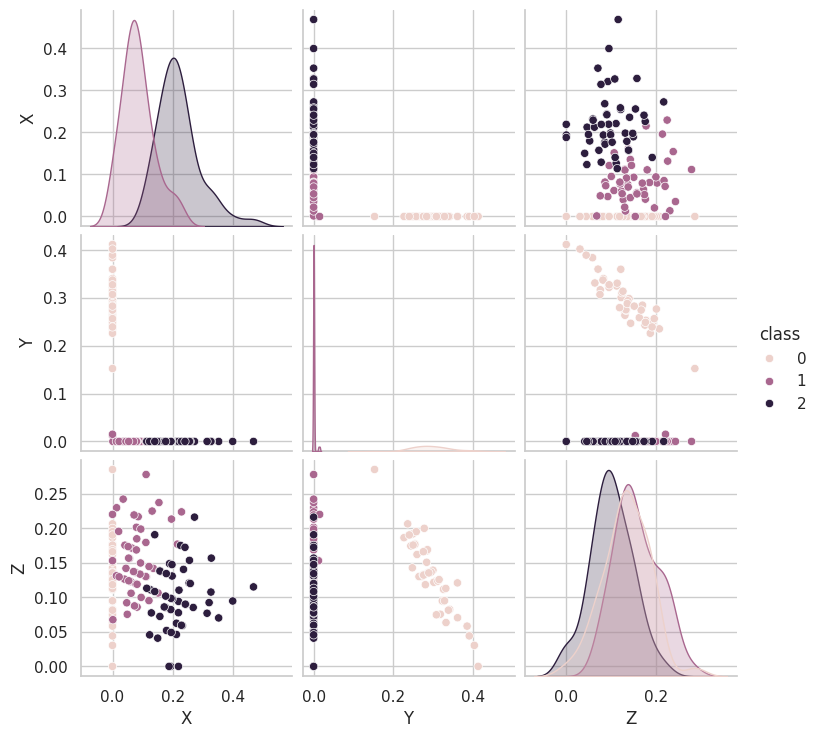

In [96]:
data_X = torch.tensor(X, dtype=torch.float32).to(device)
Y_pred = autoencoder.encoder(data_X).tolist()
df_Y_pred  = pd.DataFrame(Y_pred, columns=['X', 'Y', 'Z'])
Y_class = pd.DataFrame(y , columns=['class'])
df = pd.merge(df_Y_pred, Y_class, left_index=True, right_index=True, suffixes=('_train', '_test'))

 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot


ax.scatter(df[df['class'] == 0]['X'], df[df['class'] == 0]['Y'], df[df['class'] == 0]['Z'], c='blue', marker='o', label='class 0')
ax.scatter(df[df['class'] == 1]['X'], df[df['class'] == 1]['Y'], df[df['class'] == 1]['Z'], c='red', marker='x', label='class 1')
ax.scatter(df[df['class'] == 2]['X'], df[df['class'] == 2]['Y'], df[df['class'] == 2]['Z'], c='green', marker='^', label='class 2')


plt.show()
 
 
sns.pairplot(df , hue="class")
plt.show()

# So we can easily make a KNN that will make clusters for the data.
***The goal is achieved***  : we make an autoencoder that classifies the data unsupervisedly. 

***NOW***  
in theory:
1. We can change the input to words after tokenizing it using pretrained Word2Vec.
2. In the encoder and decoder, we need to add an LSTM, and it should be able to classify the data unsupervisedly."

In [81]:
df

,X,Y,Z,class,cluster
0,0.000000,0.309931,0.124194,0,1
1,0.000000,0.242392,0.190636,0,1
2,0.000000,0.280787,0.167428,0,1
3,0.000000,0.253677,0.177550,0,1
4,0.000000,0.325506,0.111711,0,1
...,...,...,...,...,...
145,0.194591,0.000000,0.098605,2,2
146,0.241049,0.000000,0.172556,2,2
147,0.176754,0.000000,0.101891,2,2
148,0.123568,0.000000,0.045740,2,2


In [74]:
optimizer.state_dict() , autoencoder.state_dict() ,torch.save(autoencoder, "./autoencoder.pth")

({'state': {0: {'step': tensor(36000.),
    'exp_avg': tensor([[-0.0080, -0.0012,  0.0105,  0.0141],
            [-0.0247,  0.0448, -0.0454, -0.0460],
            [-0.0962, -0.0989,  0.0279,  0.0343]]),
    'exp_avg_sq': tensor([[0.0550, 0.0420, 0.0568, 0.0571],
            [0.0491, 0.0599, 0.0825, 0.0771],
            [2.2077, 2.0286, 2.8054, 2.6564]])},
   1: {'step': tensor(36000.),
    'exp_avg': tensor([0.0030, 0.0350, 0.0070]),
    'exp_avg_sq': tensor([0.1104, 0.0491, 2.7603])},
   2: {'step': tensor(36000.),
    'exp_avg': tensor([[-0.0011, -0.0026, -0.0001],
            [ 0.0000,  0.0000,  0.0000],
            [-0.0019,  0.0025,  0.0019],
            [ 0.0024, -0.0013, -0.0001]]),
    'exp_avg_sq': tensor([[0.0005, 0.0005, 0.0004],
            [0.0000, 0.0000, 0.0000],
            [0.0009, 0.0007, 0.0007],
            [0.0022, 0.0015, 0.0018]])},
   3: {'step': tensor(36000.),
    'exp_avg': tensor([-0.0076,  0.0000,  0.0113,  0.0027]),
    'exp_avg_sq': tensor([0.0225, 0.0000

In [25]:
checkpoint = {
    'epoch': 8000,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, 'checkpoint_autoencoder.pth')

In [76]:
X_encoded , y_class = df[['X', 'Y' , 'Z']]  ,df['class'] 
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_class, test_size=0.2, random_state=42)

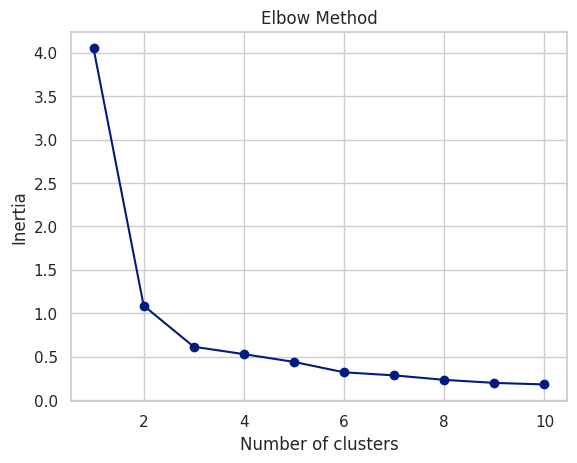

In [77]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_encoded)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve to determine the optimal number of clusters
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
"""
we have 3 cluster but this is just me being cerues 
"""
plt.show()

In [78]:
classifyer = KMeans(n_clusters=3, random_state=42)
classifyer.fit(X_train_encoded)

KMeans(n_clusters=3, random_state=42)

In [79]:
def pred(row):
    # Extract features 'X', 'Y', 'Z' from the row
    features = row[['X', 'Y', 'Z']].values.reshape(1, -1)
    # Predict the cluster using the trained classifier
    return classifyer.predict(features)[0]

# Apply the prediction function to each row in the DataFrame 'df'
df['cluster'] = df.apply(pred, axis=1)

/home/mohammedaouamri/DEV/ML/pendulem/coder_decoder/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/mohammedaouamri/DEV/ML/pendulem/coder_decoder/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/mohammedaouamri/DEV/ML/pendulem/coder_decoder/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/mohammedaouamri/DEV/ML/pendulem/coder_decoder/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

/home/mohammedaouamri/DEV/ML/pendulem/coder_decoder/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature na

In [86]:
df["cluster"]

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: cluster, Length: 150, dtype: int32

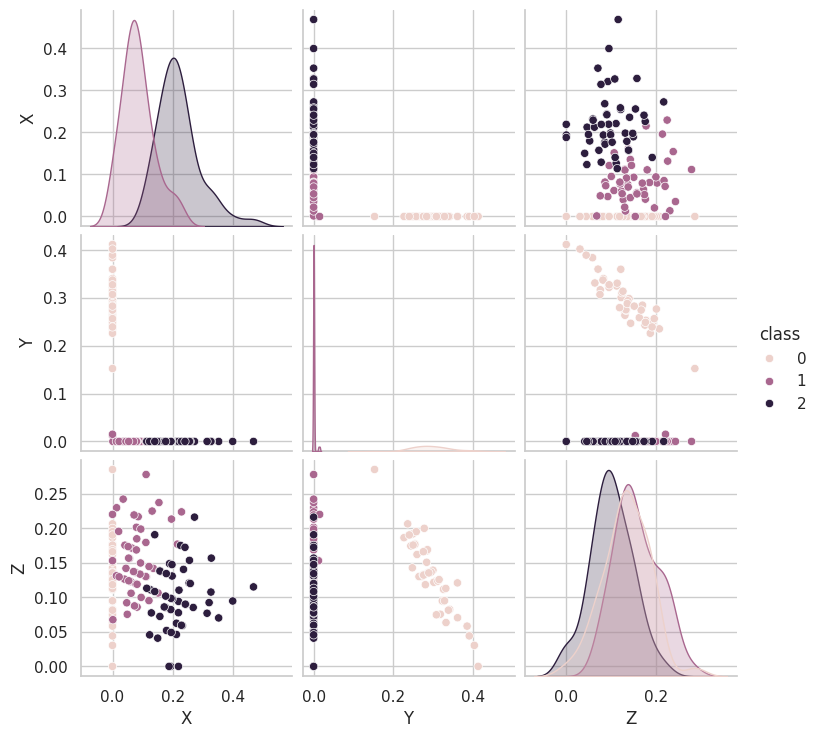

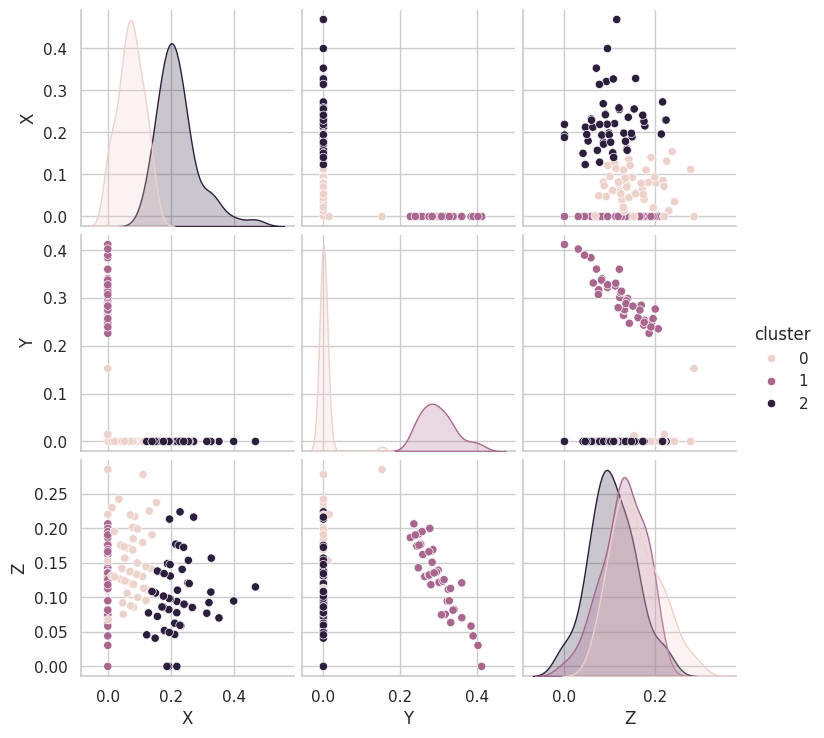

In [94]:
sns.pairplot(df.drop(columns='cluster') , hue='class')
plt.show()

sns.pairplot(df.drop(columns='class'), hue='cluster')
plt.show()
